In [3]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
from datasets import load_dataset
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vit_b_16

/Users/aliyatang/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [4]:
# Load the dataset
df = pd.read_csv('annotations.csv')
data = []
for _, row in df.iterrows():
    data.append({
        "image_path": row['image_path'],
        "bbox": [row['x_start'], row['y_start'], row['x_end'], row['y_end']],
        "label": row['class_label']
    })
image_paths = df['image_path'].tolist()
labels = df['class_label']

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

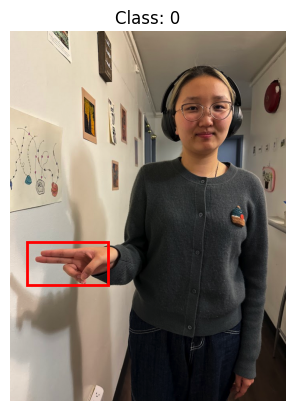

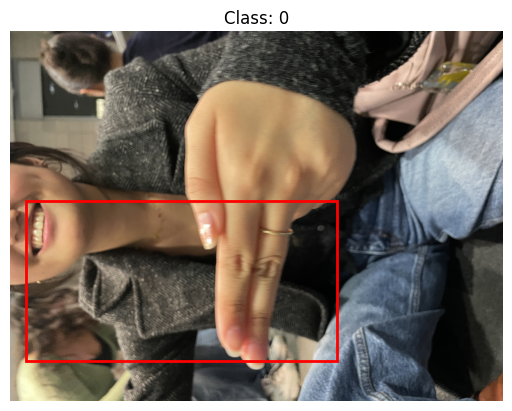

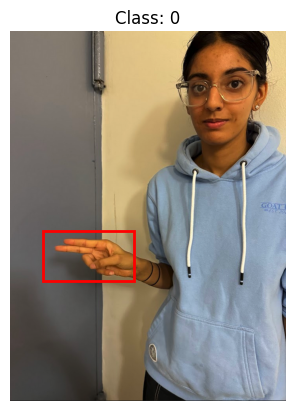

In [6]:
def visualize_image(row):
    # Load the image
    img = Image.open(row['image_path'])
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Add bounding box
    x_start, y_start, x_end, y_end = row['x_start'], row['y_start'], row['x_end'], row['y_end']
    width = x_end - x_start
    height = y_end - y_start
    rect = patches.Rectangle((x_start, y_start), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    # Add class label as title
    plt.title(f"Class: {row['class_label']}")
    plt.axis('off')
    plt.show()

# Visualize a few samples
for i in range(3):  # Change the range for more samples
    visualize_image(df.iloc[i])

In [7]:
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Define custom dataset
class VisionDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = row['image_path']
        bbox = torch.tensor([row['x_start'], row['y_start'], row['x_end'], row['y_end']])
        label = torch.tensor(row['class_label'])

        # Load and preprocess image
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, bbox, label

# Define transformations for ViT input
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for ViT
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create dataset and dataloader
dataset = VisionDataset(df, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


In [8]:
# Load pre-trained ViT model
class VisionTransformerModel(nn.Module):
    def __init__(self, num_classes):
        super(VisionTransformerModel, self).__init__()
        self.vit = vit_b_16(pretrained=True)
        self.vit.heads = nn.Identity()  # Remove the classification head
        
        # Add custom heads
        self.class_head = nn.Linear(768, num_classes)  # For classification
        self.bbox_head = nn.Linear(768, 4)            # For bounding box regression

    def forward(self, x):
        x = self.vit(x)
        class_out = self.class_head(x)
        bbox_out = self.bbox_head(x)
        return class_out, bbox_out

# Define the model
num_classes = df['class_label'].nunique()
model = VisionTransformerModel(num_classes=num_classes)


/Users/aliyatang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/aliyatang/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Change the device cuz rn it's mps 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model.to(device)

# Loss functions
classification_loss_fn = nn.CrossEntropyLoss()
bbox_loss_fn = nn.SmoothL1Loss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_class_loss = 0
    epoch_bbox_loss = 0

    for images, bboxes, labels in dataloader:
        images, bboxes, labels = images.to(device), bboxes.to(device), labels.to(device)

        # Forward pass
        class_out, bbox_out = model(images)

        # Compute losses
        class_loss = classification_loss_fn(class_out, labels)
        bbox_loss = bbox_loss_fn(bbox_out, bboxes)

        # Total loss
        total_loss = class_loss + bbox_loss

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Record losses
        epoch_class_loss += class_loss.item()
        epoch_bbox_loss += bbox_loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Classification Loss: {epoch_class_loss:.4f}, BBox Loss: {epoch_bbox_loss:.4f}")


Using device: mps
